**Rozdział 3. Klasyfikacja**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 3._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R03"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Zestaw danych MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

Zapisywanie rysunku przykładowa_cyfra


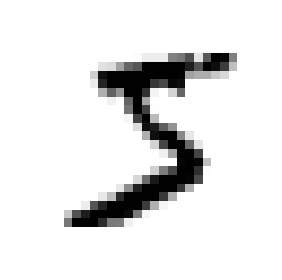

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("przykładowa_cyfra")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# BONUS
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Zapisywanie rysunku r_3_1


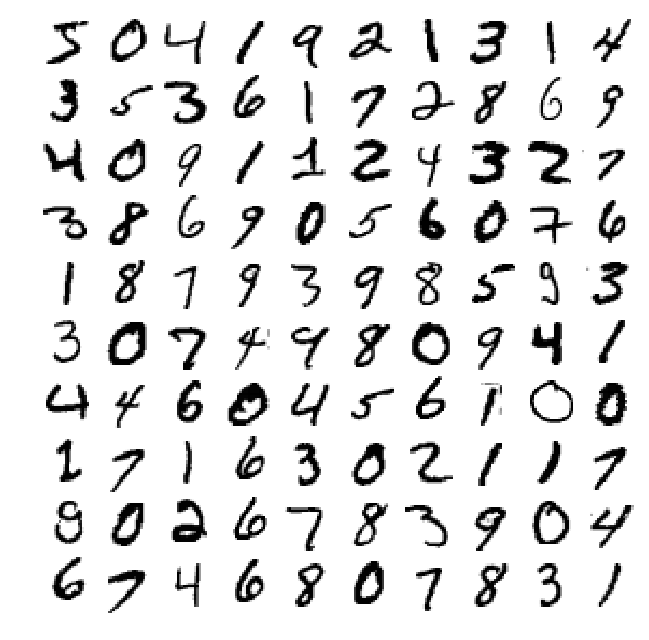

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("r_3_1")
plt.show()

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Klasyfikator binarny

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Uwaga**: niektóre hiperparametry, takie jak `max_iter` i `tol`, będą miały inne wartości domyślne w przyszłych wersjach modułu Scikit-Learn. Na wszelki wypadek wyznaczam tu jawnie te przyszłe wartości domyślnie. Dla uproszczenia nie zaprezentowałem tego w książce.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
y_train_perfect_predictions = y_train_5  # udajemy, że uzyskaliśmy wynik idealny
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
4096 / (4096 + 1522)

0.7290850836596654

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
4096 / (4096 + 1325)

0.7555801512636044

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [29]:
4096 / (4096 + (1522 + 1325) / 2)

0.7420962043663375

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [32]:
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Zapisywanie rysunku r_3_4


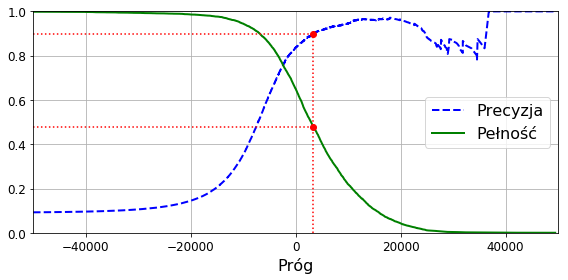

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Pełność", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Nieukazane w książce
    plt.xlabel("Próg", fontsize=16)             # Nieukazane
    plt.grid(True)                              # Nieukazane
    plt.axis([-50000, 50000, 0, 1])             # Nieukazane



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Nieukazane
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Nieukazane
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Nieukazane
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Nieukazane
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Nieukazane
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Nieukazane
save_fig("r_3_4")                                              # Nieukazane
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

Zapisywanie rysunku r_3_5


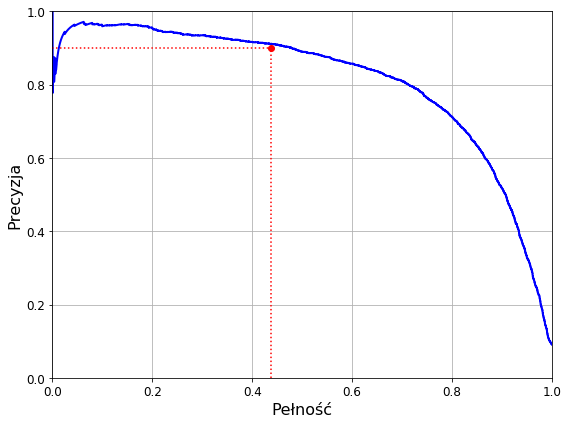

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Pełność", fontsize=16)
    plt.ylabel("Precyzja", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("r_3_5")
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# Krzywe ROC

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Zapisywanie rysunku r_3_6


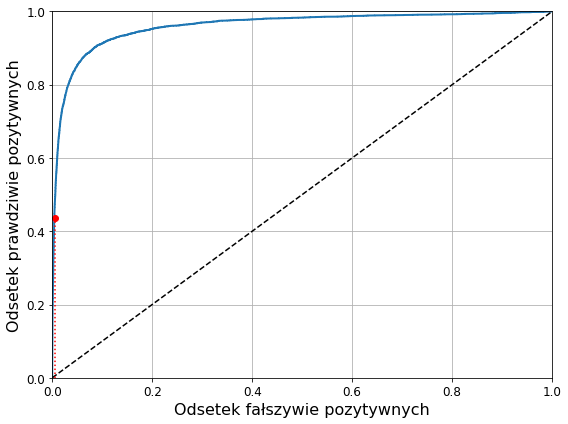

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # przerywana linia ukośna
    plt.axis([0, 1, 0, 1])                                       # Nieukazane w książce
    plt.xlabel('Odsetek fałszywie pozytywnych', fontsize=16)     # Nieukazane
    plt.ylabel('Odsetek prawdziwie pozytywnych', fontsize=16)    # Nieukazane
    plt.grid(True)                                               # Nieukazane

plt.figure(figsize=(8, 6))                         # Nieukazane
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Nieukazane
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Nieukazane
plt.plot([4.837e-3], [0.4368], "ro")               # Nieukazane
save_fig("r_3_6")                         # Nieukazane
plt.show()

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Uwaga**: wyznaczamy `n_estimators=100` na przyszłość, ponieważ będzie to wartość domyślna w module Scikit-Learn 0.22.

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # wynik = prawdopodobieństwo przynależności do klasy pozytywnej
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Zapisywanie rysunku r_3_7


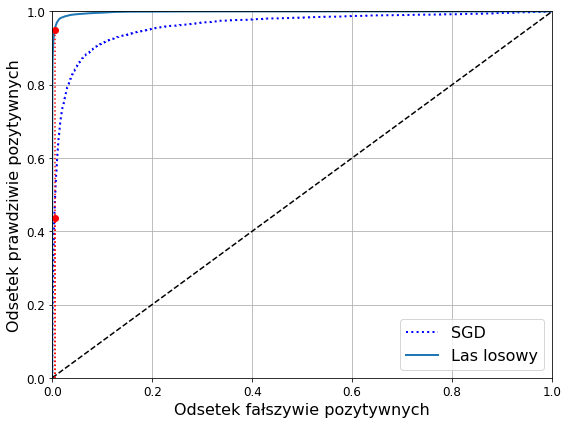

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Las losowy")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("r_3_7")
plt.show()

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [51]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [52]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Klasyfikacja wieloklasowa

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [55]:
np.argmax(some_digit_scores)

5

In [56]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]

5

In [58]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
len(ovr_clf.estimators_)

10

In [60]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [61]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\Krzysztof\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

In [65]:
def plot_confusion_matrix(matrix):
    """Jeśli wolisz wersję kolorową"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Zapisywanie rysunku macierz_pomyłek


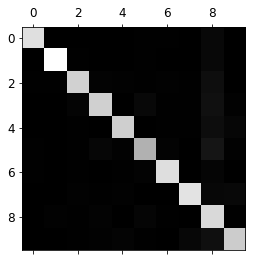

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("macierz_pomyłek", tight_layout=False)
plt.show()

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Zapisywanie rysunku macierz_pomyłek_błędy


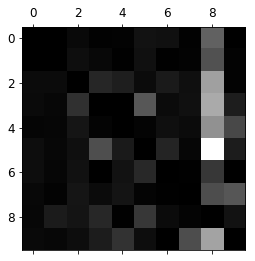

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("macierz_pomyłek_błędy", tight_layout=False)
plt.show()

Zapisywanie rysunku analiza_błędów_cyfry


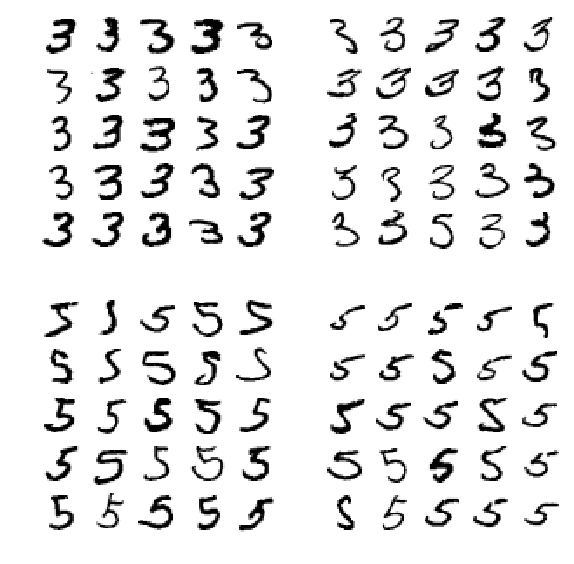

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("analiza_błędów_cyfry")
plt.show()

# Klasyfikacja wieloetykietowa

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Ostrzeżenie**: poniższa komórka może być przetwarzana przez bardzo długi czas (w zależności od sprzętu może to zająć całe godziny).

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput classification

In [72]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Zapisywanie rysunku cyfra_zaszumiona


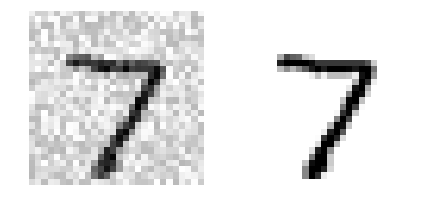

In [73]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("cyfra_zaszumiona")
plt.show()

Zapisywanie rysunku cyfra_oczyszczona


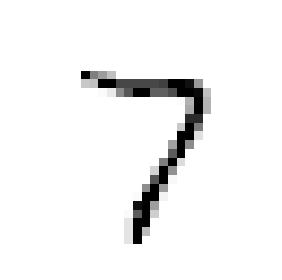

In [74]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cyfra_oczyszczona")

# Materiały dodatkowe

## Klasyfikator prosty (np. losowy)

In [75]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

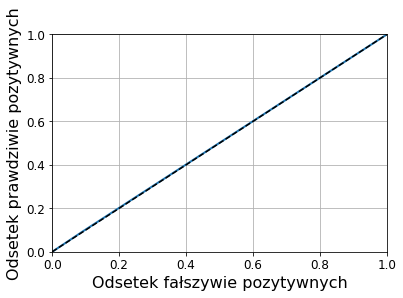

In [76]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Klasyfikator KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [78]:
y_knn_pred = knn_clf.predict(X_test)

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

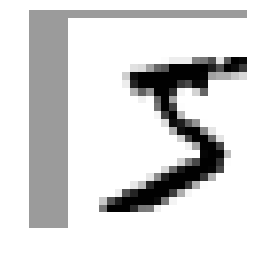

In [80]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [81]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [82]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [83]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [85]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [86]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

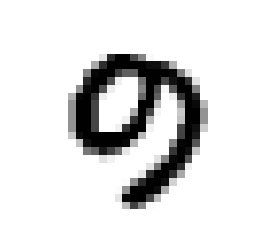

In [87]:
plot_digit(ambiguous_digit)

# Rozwiązania ćwiczeń

## 1. Klasyfikator obrazów MNIST z dokładnością przekraczającą 97%

**Ostrzeżenie**: poniższa komórka może być przetwarzana bardzo długo w zależności od sprzętu.

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, weights=uniform, score=0.9717617659308622, total=10.9min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 52.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.9706715547408765, total=10.7min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 103.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.9689166666666666, total=10.1min
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.968575477202634, total=11.0min
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9704068022674225, total=11.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9723448563098709, total=10.9min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9716713881019831, total=11.2min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9700833333333333, total= 9.9min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9700758522964075, total=10.0min
[CV] n_neighbors=3, weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 1523.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [89]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [90]:
grid_search.best_score_

0.9716166666666667

In [91]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Dogenerowanie danych

In [84]:
from scipy.ndimage.interpolation import shift

In [85]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

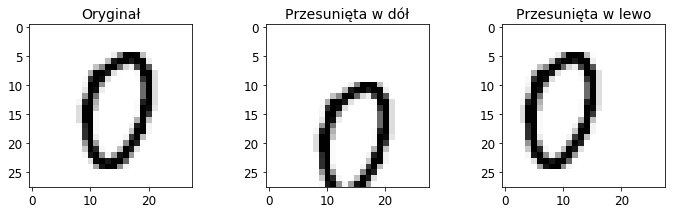

In [86]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Oryginał", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Przesunięta w dół", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Przesunięta w lewo", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [87]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [88]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [99]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

Dzięki samemu dogenerowaniu danych zwiększyliśmy dokładność o 0,5%! :)

## 3. Zestaw danych Titanic

Celem jest uzyskanie prognozy, czy dany pasażer przeżył katastrofę na podstawie takich atrybutów jak jego wiek, płeć, klasa, jaką płynie pasażer, port, w którym wszedł na pokład itd.

Najpierw zaloguj się w serwisie [Kaggle](https://www.kaggle.com/) i przejdź do [wyzwania Titanic](https://www.kaggle.com/c/titanic), skąd możesz pobrać pliki `train.csv` i `test.csv`. Zapisz je w katalogu `zestawy danych/titanic`.

Next, let's load the data:

In [100]:
import os

TITANIC_PATH = os.path.join("zestawy danych", "titanic")

In [101]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [102]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Dane są już rozdzielone na zbiory uczący i testowy. Jednak dane testowe *nie* zawierają etykiet. Naszym zadaniem jest wytrenowanie jak najlepszego modelu za pomocą za pomocą danych uczących, a następnie uzyskanie prognoz wobec danych testowych i przesłanie wyników do serwisu Kaggle w celu uzyskania ostatecznej oceny.

Przyjrzyjmy się kilku pierwszym rzędom zestawu uczącego:

In [103]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Atrybuty mają następujące znaczenie:
* **Survived** (przetrwał): jest to nasza klasa docelowa; 0 oznacza, że pasażer nie przeżył, a 1, że przetrwał.
* **Pclass** (klasa): klasa pasażera.
* **Name**, **Sex**, **Age** (imię i nazwisko), (płeć), (wiek): nie wymagają wyjaśnienia.
* **SibSp** (rodzeństwo i partnerzy): liczba rodzeństwa i partnerów pasażera obecnych na statku.
* **Parch** (wstępni i zstępni): liczba dzieci i rodziców pasażera obecnych na statku.
* **Ticket** (bilet): identyfikator biletu.
* **Fare** (opłata): zapłacona cena za podróż (w funtach).
* **Cabin** (kajuta): numer kajuty pasażera.
* **Embarked** (miejsce wejścia): miejsce wejścia na pokład Titanica.

Przyjrzyjmy się dokładniej temu zestawowi, aby ustalić, jak wiele brakuje danych:

In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


No dobrze, zatem część atrybutów **Age**, **Cabin** i **Embarked** jest pustych (mniej niż 891 jest niezerowych); dotyczy to zwłaszcza atrybutu **Cabin** (brakuje w nim 77% wartości). Zignorujemy na razie atrybut **Cabin** i zajmiemy się pozostałymi. Atrybut **Age** zawiera około 19% pustych wartości, zatem musimy zdecydować, co z nimi zrobić. Rozsądnym pomysłem wydaje się zastąpienie brakujących wartości medianą wieku.

Atrybuty **Name** i **Ticket** mogą mieć jakąś wartość, ciężko jednak będzie przekształcić jej w przydatne cyfry zrozumiałe dla modelu. Dlatego również je na razie zignorujemy.

Sprawdźmy atrybuty numeryczne:

In [105]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Ojej, przeżyło zaledwie 38% osób (**Survived**). :(  To niemal 40%, zatem dokładność będzie odpowiednią metryką wydajności naszego modelu.
* Średnia opłata (**Fare**) wynosiła 32.20 funtów, co nie wydaje się zbyt drogo (aczkolwiek w tamtych czasach było to pewnie mnóstwo pieniędzy).
* Średni wiek (**Age**) wynosił mniej, niż 30 lat.

Sprawdźmy, czy istnieją tylko dwie wartości docelowe: 0 i 1:

In [106]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Teraz przyjrzyjmy się pobieżnie wszystkim atrybutom kategorialnym:

In [107]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [108]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [109]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Atrybut Embarked mówi nam, w którym porcie pasażera wszedł na pokład: C=Cherbourg, Q=Queenstown, S=Southampton.

**Uwaga**: w poniższym listingu korzystamy z kombinacji klas `Pipeline`, `FeatureUnion`, a także niestandardowej `DataFrameSelector`, dzięki czemu poszczególne kolumny będą przetwarzane odmiennymi sposobami. Od wersji Scikit-Learn 0.20 lepiej jest korzystać z klasy `ColumnTransformer`, tak jak zaprezentowano w poprzednim rozdziale.

Przygotujmy teraz potoki wstępnego przetwarzania. Wykorzystamy stworzoną w poprzednim rozdziale klasę `DataframeSelector` w celu dobierania określonych atrybutów z obiektu `DataFrame`:

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Stwórzmy potok dla atrybutów numerycznych:

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [112]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Potrzebujemy również klasy przypisującej dla kolumn zawierających kategorialne ciągi znaków (standardowa klasa `SimpleImputer` nie działa wobec nich):

In [113]:
# Inspirację stanowiło pytanie umieszczone na stronie stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [114]:
from sklearn.preprocessing import OneHotEncoder

Teraz możemy stworzyć potok dla atrybutów kategorialnych:

In [115]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [116]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

W końcu możemy połączyć potoki numeryczne i kategorialne:

In [117]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Świetnie! Mamy teraz do dyspozycji dobry potok przetwarzania wstępnego, który pobiera nieprzetworzone dane i na wyjściu umieszcza numeryczne cechy wejściowe, które możemy przesłać do dowolnego modelu uczenia maszynowego.

In [118]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Nie zapominajmy o etykietach:

In [119]:
y_train = train_data["Survived"]

Możemy już przystąpić do uczenia klasyfikatora. Zacznijmy od klasy `SVC`:

In [120]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Świetnie, nasz model jest wyuczony, możemy więc go użyć do obliczania prognoz wobec zbioru testowego: 

In [121]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Teraz wystarczyłoby wygenerować plik CSV przechowujący te prognozy (przy zachowaniu formatu zdefiniowanego w serwisie Kaggle), a następnie przesłać go i liczyć na dobre wyniki. Ale chwila! Możemy jeszcze dopomóc szczęściu. Możemy przecież skorzystać ze sprawdzianu krzyżowego, aby sprawdzić, jak dobry jest nasz model.

In [122]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

No dobrze, ponad 73% dokładności, zdecydowanie lepiej od czystego przypadku, ale to wcale nie jest rewelacyjny wynik. Po zajrzeniu na [listę wyników](https://www.kaggle.com/c/titanic/leaderboard) w serwisie Kaggle okazuje się, że musimy osiągnąć dokładność powyżej 80%, aby model znalazł się w najlepszych 10% algorytmów dla tego wyzwania. Niektóre modele osiągają 100% dokładności, ale skoro możemy z łatwością znaleźć [listę ofiar](https://www.encyclopedia-titanica.org/titanic-victims/), możemy śmiało przypuszczć, że na taką wydajność uczenie maszynowe miało niewielki wpływ! ;-) Spróbujmy zatem stworzyć model uzyskujący 80% dokładności.

Zobaczmy, jakie wyniki uzyskamy za pomocą klasy `RandomForestClassifier`:

In [123]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

To jest o wiele lepszy wynik!

Zamiast sprawdzać średnią dokładność dla każdej grupy w dziesięciokrotnym sprawdzianie krzyżowym możemy stworzyć wykres pudełkowy wszystkich dziesięciu wyników dla każdego modelu, na którym zaznaczymy kwartyle górne i dolne, a także wąsy. ukazujące zakres wyników (ten sposób wizualizacji został zasugerowany przez Nevina Yilmaza). Zwróć uwagę, że funkcja `boxplot()` wykrywa elementy odstające i nie uwzględnia ich w ramach wąsów. Mówiąc dokładniej, jeśli kwartyl dolny ma symbol $Q_1$, a kwartyl górny oznaczymy jako $Q_3$, to zakres międzykwartylowy $IQR = Q_3 - Q_1$ (wysokość pudełka), a każdy wynik mniejszy od $Q_1 - 1.5 \times IQR$ stanowi element odstający, podobnie jak każdy wynik większy niż $Q3 + 1.5 \times IQR$.

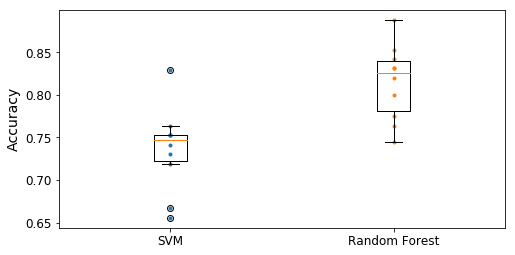

In [124]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Las losowy"))
plt.ylabel("Dokładność", fontsize=14)
plt.show()

W celu dalszego poprawienia wyniku możesz:
* porównać wydajność wielu innych modeli i dostroić hiperparametry za pomocą sprawdzianu krzyżowego i przeszukiwania siatki,
* poświęcić więcej czasu na inżynierię cech, na przykład:
  * zastąpić atrybuty **SibSp** i **Parch** ich sumą,
  * spróbować określić pewne składniki tytułu pasażera wykazujące korelację z atrybutem **Survived** (np. jeśli dana osoba miała tytuł "Countess", czyli hrabina, to mogła mieć większą szansę na przeżycie),
* spróbuj przetworzyć atrybuty numeryczne na kategorialne: przykładowo odmienne grupy wiekowe mają różny współczynnik przetrwania (patrz niżej), co może pomóc w utworzeniu kategorii przedziałów wiekowych, z której możemy korzystać zamiast wieku. W podobny sposób możemy stworzyć kategorię określającą samotnych pasażerów, gdyż przetrwało ich zaledwie 30% (patrz niżej).

In [125]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [126]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Klasyfikator spamu

Pobierzmy najpierw dane:

In [127]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("zestawy danych", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [128]:
fetch_spam_data()

Wczytajmy teraz wszystkie wiadomości email:

In [129]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [130]:
len(ham_filenames)

2500

In [131]:
len(spam_filenames)

500

Możemy wykorzystać moduł `email` do analizowania składni tych wiadomości (nagłówków, kodowania itd.):

In [132]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [133]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Spójrzmy na jeden przykład hamu i spamu, aby przekonać się, jak wyglądają przetwarzane dane:

In [134]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [135]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Niektóre wiadomości są w rzeczywistości wieloczęściowe i zawierają obrazy oraz załączniki (które mogą przechowywać swoje własne załączniki). Przyjrzyjmy się różnym typom używanych struktur danych:

In [136]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [137]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [138]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [139]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Wygląda na to, że prawidłowe wiadomości email często składają się w większości ze zwykłego tekstu, natomiast w spamie znajdziemy mnóstwo znaczników HTML. Co więcej, niektóre wiadomości ham są podpisane za pomocą PGP, czego nie można powiedzieć o spamie. Mówiąc krótko, wydaje się, że struktura wiadomości email przechowuje dość cenne informacje.

Przeanalizujmy teraz nagłówki:

In [140]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

ZNajdziemy tu prawdopodobnie mnóstwo przydatnych informacji, takich jak adres email nadawcy (adres 12a1mailbot1@web.de wygląda podejrzanie), skoncentrujemy się jednak wyłącznie na nagłówku `Subject`:

In [141]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

No dobrze, zanim dowiemy się zbyt wiele na temat danych, nie zapomnijmy rozdzielić je na zbiory uczący i testowy:

In [142]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Możemy zająć się tworzeniem funkcji przetwarzania wstępnego. Najpierw przyda nam się funkcja przekształcająca składnię HTML w zwykły tekst. Prawdopodobnie najlepszym rozwiązaniem byłoby użycie znakomitej biblioteki [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), chciałbym jednak uniknąć dodawania kolejnych zależności do tego projektu, dlatego wybieramy niezbyt elegancką metodę wykorzystującej wyrażenia regularne (ryzykując jednocześnie [bezbo҉żny bląśk ńiszczący całé o͞świ̍̈́̂̈́ecénie](https://stackoverflow.com/a/1732454/38626)). Poniższa funkcja najpierw usuwa sekcję `<head>`, następnie przekształca wszystkie znaczniki `<a>` w wyraz HIPERŁACZA, pozbywa się wszystkich pozostałych znaczników HTML pozostawiając sam tekst. W celu zwiększenia czytelności redukuje liczbę końców linii i pomija cytowanie elementów HTML (takich jak `&gt;` czy `&nbsp;`):

In [143]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Zobaczmy, jak działa nasze rozwiązanie. Tak wygląda spam w formacie HTML:

In [144]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

A tak wygląda ta sama wiadomość po potraktowaniu jej naszą nową funkcją:

In [145]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Znakomicie! Napiszmy teraz funkcję pobierającą daną wiadomość i zwracającą jej treść w postaci zwykłego tekstu, bez względu na jej format:

In [146]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # w przypadku problemów z kodowaniem
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [147]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Wprowadźmy analizę słowotwóczą! Będziemy potrzebować w tym celu narzędzia Natural Language Toolkit ([NLTK](http://www.nltk.org/)). Aby go zainstalować, wystarczy wpisać poniższe polecenie (nie zapomnij uaktywnić najpierw swojego środowiska wirtulanego; jeśli go nie używasz, będą Tobie potrzebne uprawnienia administratora lub opcja `--user`):

`$ pip3 install nltk`

In [148]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Błąd: proces analizy słowotwórczej wymaga modułu NLTK.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


Potrzebny jest nam również mechanizm zastępowania adresów URL wyrazem "URL". Moglibyśmy skorzystać bezpośrednio z [wyrażeń regularnych](https://mathiasbynens.be/demo/url-regex), ale użyjemy po prostu biblioteki [urlextract](https://github.com/lipoja/URLExtract). Możemy ją zainstalować przy użyciu poniższej komendy (nie zapomnij uaktywnić najpierw swojego środowiska wirtualnego; jeśli go nie używasz, będą Tobie potrzebne uprawnienia administratora lub opcja `--user`):

`$ pip3 install urlextract`

In [149]:
# jeżeli przetwarzasz ten notatnik w środowisku Colab, korzystamy jedtnie z pip install urlextract
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [150]:
try:
    import urlextract # może wymagać połączenia internetowego w celu pobrania głównych nazw domenowych
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Czy wykryje github.com i https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Błąd: zastępowanie adresów URL wymaga obecności modułu urlextract.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Możemy teraz poskładać te elementy w jeden transformator, za pomocą którego będziemy przetwarzać wiadomości email w liczniki słów. Zwróć uwagę, że rozdzielamy zdania na poszczególne słowa za pomocą metody `split()`, rozdzielając wyrazy za pomocą znaków odstępu. Rozwiązanie to jest skuteczne w przypadku wielu, ale nie wszystkich języków pisanych. Na przykład chińskie i japońskie skrypty zazwyczaj nie mają odstępów pomiędzy wyrazami, natomiast w języku wietnamskim odstępy występują często pomiędzy sylabami. W naszym przykładzie nie stanowi to problemu, ponieważ w stosowanym przez nas zbiorze danych występuje (głównie) język angielski.

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Wypróbujmy transformator na kilku wiadomościach email:

In [152]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

Wygląda to wcale nieźle!

Mamy już liczniki słów, zatem teraz musimy je przekształcić do postaci wektorowej. W tym celu przygotujemy jeszcze jeden transformator, którego metoda `fit()` będzie tworzyła słownik (uporządkowaną listę najczęściej pojawiających się słów); z kolei metoda `transform()` będzie używać tego słownika do przekształcania zliczeń wyrazów w wektory. W wyniku tej funkcji otrzymujemy macierz rzadką:

In [153]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [154]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [155]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  1,  3,  3,  1,  3,  2,  3],
       [65,  0,  1,  2,  5,  3,  1,  2,  0,  1,  0]], dtype=int64)

Co ta macierz oznacza? Wartość 99 w drugim rzędzie i pierwszej kolumnie oznacza, że druga wiadomość email zawiera 99 wyrazów niebędących częścią słownika. Widoczna obok wartość 11 oznacza, że pierwszy wyraz w słowniku występuje 11 razy w tej wiadomości. Kolejna wartość, 9, oznacza, że drugi wyraz pojawił się dziewięciokrotnie itd. Możesz sprawdzić słownik, aby przekonać się, jakie są to słowa. Pierwszym wyrazem jest "the", drugim "of" itd.

In [156]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

Jesteśmi gotowi do wytrenowania naszego pierwszego klasyfikatora spamu! Przekształćmy cały zbiór danych: 

In [157]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Uwaga**: na wszelki wypadek wyznaczamy `solver="lbfgs"`, ponieważ wartość ta będzie domyślna w module Scikit-Learn 0.22.

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.9925, total=   0.1s


/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


0.9874999999999999

Ponad 98.7% dokładności, nieźle jak na pierwszą próbę! :) Pamiętaj jednak, że korzystamy z "łatwego" zbioru danych. Możesz wypróbować trudniejsze zbiory danych, ale wyniki nie będą już tak zdumiewające. Należałoby wypróbować wiele różnych modeli, wybrać najlepsze z nich, dostroić je za pomocą sprawdzianu krzyżowego itd.

Wiesz już jednak, jak ten proces wygląda, zatem poprzestańmy na tym i sprawdźmy jeszcze tylko wynik precyzji/pełności na zestawie testowym:

In [159]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precyzja: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Pełność: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%


/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
